In [674]:
# Importamos librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import re

In [486]:
#levantamos el dataset y verificamos

data = pd.read_csv('../properties_colombia_train.csv')
data.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


In [487]:
# reservo el valor de la media de precio original en una variable; para referencia posterior.
media_precio_orig = data['price'].mean()
print(media_precio_orig)

643605091.0064613


In [488]:
#vemos una descripcion preliminar de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

In [489]:
data.describe()

,Unnamed: 0,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,197549.000000,148051.000000,148051.000000,27537.000000,40525.000000,156467.000000,6974.000000,9.802000e+03,1.974860e+05
mean,497437.843851,5.666001,-75.041045,3.291208,3.239062,2.639279,1352.132349,9.483356e+02,6.436051e+08
std,290023.578338,2.196804,1.104575,1.754795,1.985636,1.437174,7713.769352,3.730875e+04,1.944868e+09
min,0.000000,-32.787342,-119.698190,1.000000,0.000000,1.000000,10.000000,1.000000e+00,0.000000e+00
25%,234211.000000,4.582315,-75.645126,3.000000,3.000000,2.000000,72.000000,7.100000e+01,2.000000e+08
50%,507385.000000,4.908611,-75.476654,3.000000,3.000000,2.000000,120.000000,1.140000e+02,3.300000e+08
75%,770037.000000,6.248101,-74.094001,4.000000,4.000000,3.000000,281.000000,2.160000e+02,6.000000e+08
max,993551.000000,34.420334,-67.482570,40.000000,96.000000,20.000000,180000.000000,3.480000e+06,3.450000e+11


## Datos Duplicados

In [490]:
# Revisamos si hay registros duplicados, registros duplicados en la col 'id', o registros duplicados en la col 'Unnamed: 0'
# ya que sobre estas últimas 2 columnas, quizas hubiera info redundante. Ej una propiedad publicada en más de una oportunidad
# con una actualizacion de precio

print(data[data.duplicated()])
print(data[data.duplicated('Unnamed: 0')])
print(data[data.duplicated('id')])

# Salen 3 Empty dataframes
# no hay datos redundantes

Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]


## Datos Faltantes

In [491]:
# 1- vemos las cols con datos faltantes, y cuántos:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 49498
lon                 49498
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [492]:
#columna ad_type no tiene nulos, pero la vemos. Es monovalor.
data['ad_type'].value_counts()

Propiedad    197549
Name: ad_type, dtype: int64

In [493]:
# Columnas lat y lon.
# Estas serán muy importantes para nuestro modelo. Intentaremos reconstruir los faltantes usando la info disponible en
# otras columnas l1, l2, l3, l4, l5, l6 y geometry.

# primero entendamos la logica de l1 a l6.
# l1 es pais, l2 es provincia, l3 es ciudad, l4 barrio/zona, etc. siendo cada vez más descriptivo de la ubiucación.
# Viendo los faltantes vemos que l1 y l2 estan completas, luego a l3 le faltan algunos datos, a l4 aun más, a l5 y a l6 aún más.
# podriamos pensar en ppo que si l6 esta completa, entonces tb lo estan las anteriores.

In [494]:
# verifiquemosló
# 
print('cant. de nulos en l5, siendo que l6 esta completa:\n\t',data[data['l6'].isnull()==False]['l5'].isnull().sum())
print('cant. de nulos en l4, siendo que l5 esta completa:\n\t',data[data['l5'].isnull()==False]['l4'].isnull().sum())
print('cant. de nulos en l3, siendo que l4 esta completa:\n\t',data[data['l4'].isnull()==False]['l3'].isnull().sum())
print('cant. de nulos en l2, siendo que l3 esta completa:\n\t',data[data['l3'].isnull()==False]['l2'].isnull().sum())
print('cant. de nulos en l1, siendo que l2 esta completa:\n\t',data[data['l2'].isnull()==False]['l1'].isnull().sum())

cant. de nulos en l5, siendo que l6 esta completa:
	 0
cant. de nulos en l4, siendo que l5 esta completa:
	 0
cant. de nulos en l3, siendo que l4 esta completa:
	 0
cant. de nulos en l2, siendo que l3 esta completa:
	 0
cant. de nulos en l1, siendo que l2 esta completa:
	 0


In [495]:
# Plan para imputar lat y long. Vamos a usar la libreria geopy para inferir datos genericos de lat y long
# a partir de la info de las cols 'l1, l2 y l3'. Intenté con las demás pero muchas veces da error y no funciona
# con info de las zonas de las ciudades; hasta el nivel de l3 (ciudades) funciona bien con lo cual usamos hasta esa col.
# creamos una función que permita hacer justamente eso, obtener con geopy lat y long genericos para al menos ubicar la propiedad
# en un punto de la ciudad en cuestión.

In [496]:
#data['l3']=data['l3'].astype(str)

In [497]:
#data[data['l3']=='nan']['l3']=''

In [498]:
#data['location']=  data['l1']+', '+data['l2']+', '+data['l3']


In [499]:
#data['location']=data['location'].apply(lambda x: x.replace(', nan',''))
#data['location'].replace(', nan','')

In [500]:
#data['location'].value_counts()

Colombia, Antioquia, Medellín            43404
Colombia, Cundinamarca, Bogotá D.C       28731
Colombia, Valle del Cauca, Cali          20846
Colombia, Atlántico, Barranquilla        15133
Colombia, Caldas, Manizales              14128
                                         ...  
Colombia, Tolima, Icononzo                   1
Colombia, Boyacá, Tibasosa                   1
Colombia, Quindío, Circasia                  1
Colombia, Vichada, Puerto Carreño            1
Colombia, Cundinamarca, Quebradanegra        1
Name: location, Length: 329, dtype: int64

In [501]:
#data['l1']=data['l1'].apply(lambda x: x.strip())
#data['l2']=data['l2'].apply(lambda x: x.strip())
#data['l3']=data['l3'].apply(lambda x: x.strip())

In [502]:
# genero función para llenar columna latitud y luego longitud. Se hace en 2 partes porque demora bastante.

def llenar_latitud(data):
    ''' Esta función recibe el dataframe y rellena los valores de la columna lat,
        también saca otuliers basado en la distancia entre el dato y el valor teórico'''

    # en esta parte creo un dataframe con todos los valores unicos del string 'l1, l2, l3'
    data['l3']=data['l3'].astype(str)
    ubicacion = pd.DataFrame()
    ubicacion['location'] = data['l1']+', '+data['l2']+', '+data['l3']
    ubicacion['location']=ubicacion['location'].apply(lambda x: x.replace(', nan',''))
    ubicacion.drop_duplicates(inplace=True)

    # en esta parte agrego al nuevo DF 'ubicacion' una columna con la latitud obtenida con geopy
    geolocator = Nominatim(user_agent='hola')
    ubicacion['lat']=ubicacion['location'].apply(lambda x: geolocator.geocode(x).latitude)

    # agrego al dataframe original (de input) una columna con el mismo dato de ubicacion para usar como join en el posterior merge
    data['location']=  data['l1']+', '+data['l2']+', '+data['l3']
    data['location']=data['location'].apply(lambda x: x.replace(', nan',''))

    # hago el merge
    data=data.merge(right= ubicacion, how='left', left_on='location', right_on='location')

    # lleno nulos de la columna lat_x (original) por lat_y (nueva columna con el dato inferido)
    data['lat_x'].fillna(data['lat_y'], inplace=True)

    # agrego una columna c/ distancia en la latitud desde dato hasta teórico
    data['dist']=0
    for i in range(0,len(data)):
        a=(data['lat_x'][i],0)
        b=(data['lat_y'][i],0)
        data['dist'][i]=geodesic(a,b).kilometers

    # Si la distancia entre el dato original de latitud y el dato teorico de latitud es > 150km
    # entonces imputo en dato el valor teórico
    # 150 km es el radio aproximado de la ciudad más grande de Colombia; y ese radio proyectado en un eje es aprox 100km
    radio_proy = 100
    data['dist']=data['dist'].astype(float)
    data.loc[data[data['dist']>radio_proy].index,['lat_x']]=data['lat_y']
    # borro las nuevas columnas y renombro la col lat_x por su nombre original lat
    data.drop(columns= ['location', 'lat_y', 'dist'], inplace=True)
    data.rename(columns={'lat_x': 'lat'}, inplace=True)

    return data


# genero funcion para llenar columna longitud

def llenar_longitud(data):
    ''' Esta función recibe el dataframe y rellena los valores de la columna lon,
        también saca otuliers basado en la distancia entre el dato y el valor teórico '''

    # en esta parte creo un dataframe con todos los valores unicos del string 'l1, l2, l3'
    data['l3']=data['l3'].astype(str)
    ubicacion = pd.DataFrame()
    ubicacion['location'] = data['l1']+', '+data['l2']+', '+data['l3']
    ubicacion['location']=ubicacion['location'].apply(lambda x: x.replace(', nan',''))
    ubicacion.drop_duplicates(inplace=True)

    # en esta parte agrego al nuevo DF 'ubicacion' una columna con la longitud obtenida con geopy
    geolocator = Nominatim(user_agent='hola')
    ubicacion['lon']=ubicacion['location'].apply(lambda x: geolocator.geocode(x).longitude)

    # agrego al dataframe original (de input) una columna con el mismo dato de ubicacion para usar como join en el posterior merge
    data['location']=  data['l1']+', '+data['l2']+', '+data['l3']
    data['location']=data['location'].apply(lambda x: x.replace(', nan',''))

    # hago el merge
    data=data.merge(right= ubicacion, how='left', left_on='location', right_on='location')

    # lleno nulos de la columna lat_x (original) por lat_y (nueva columna con el dato inferido)
    data['lon_x'].fillna(data['lon_y'], inplace=True)

    # agrego una columna c/ distancia en la longitud desde dato hasta teórico
    data['dist']=0
    for i in range(0,len(data)):
        a=(0,data['lon_x'][i])
        b=(0,data['lon_y'][i])
        data['dist'][i]=geodesic(a,b).kilometers

    # Si la distancia entre el dato original de latitud y el dato teorico de latitud es > 150km
    # entonces imputo en dato el valor teórico
    # 150 km es el radio aproximado de la ciudad más grande de Colombia; y ese radio proyectado en un eje es aprox 100km
    radio_proy = 100
    data['dist']=data['dist'].astype(float)
    data.loc[data[data['dist']>radio_proy].index,['lon_x']]=data['lon_y']
    # borro las nuevas columnas y renombro la col lat_x por su nombre original lat
    data.drop(columns= ['location', 'lon_y', 'dist'], inplace=True)
    data.rename(columns={'lon_x': 'lon'}, inplace=True)

    return data

In [503]:
data=llenar_latitud(data)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1260512333.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [504]:
data=llenar_longitud(data)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1260512333.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [505]:
# verificamos que están ok esas 2 columnas

data['lat'].describe()

count    197549.000000
mean          5.819936
std           2.085949
min          -4.212921
25%           4.648000
50%           5.075436
75%           6.244338
max          13.351917
Name: lat, dtype: float64

In [506]:
data['lon'].describe()

count    197549.000000
mean        -75.113659
std           1.025774
min         -81.728390
25%         -75.596783
50%         -75.525491
75%         -74.149884
max         -67.482570
Name: lon, dtype: float64

In [507]:

data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [508]:
#Vamos analizando la utilidad del proximo grupo de columnas

print('Porcentaje de nulos col rooms: \n\t', data['rooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col bedrooms: \n\t', data['bedrooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col batrooms: \n\t', data['bathrooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col surface_total: \n\t', data['surface_total'].isnull().sum()/len(data))
print('Porcentaje de nulos col surface_covered: \n\t', data['surface_covered'].isnull().sum()/len(data))


Porcentaje de nulos col rooms: 
	 0.8606067355440928
Porcentaje de nulos col bedrooms: 
	 0.7948610218224339
Porcentaje de nulos col batrooms: 
	 0.20795853180729845
Porcentaje de nulos col surface_total: 
	 0.9646973662230637
Porcentaje de nulos col surface_covered: 
	 0.9503819305590006


In [509]:
# la unica columna que al menos está llena al 80% y podría aportar utilidad al modelo es 'bathrooms'.
# Llenamos esta con la media del valor


In [510]:
def llenar_bathrooms (data):
    data['bathrooms'].fillna(data['bathrooms'].mean(), inplace=True)
    return data

In [511]:
data=llenar_bathrooms(data)

In [512]:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms               0
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [513]:
# columna price
# En primer lugar, si tengo precio faltante, descarto el dato.
# ¿Por qué? porque es justamente la variable target, no podría imputar ese dato con un valor estimado, porque es justamente para lo cual estoy armando el modelo.
# Si armo el modelo en base a datos target no certeros quizás lo confundo más.
# Veamos cuántos registros son:
print('Porcentaje de registros faltantes de precio: ', round(data['price'].isnull().sum()/len(data)*100,3),'%')


Porcentaje de registros faltantes de precio:  0.032 %


In [514]:
# avanzo con la eliminación de esos registros que son muy pocos:
data=data.drop(data[data['price'].isnull()].index)

In [780]:
# reindexo el dataframe
data.reset_index(drop = True, inplace = True)


In [515]:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152152
l5                 170103
l6                 190636
rooms              169988
bedrooms           157009
bathrooms               0
surface_total      190544
surface_covered    187731
price                   0
currency                4
price_period       161515
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [516]:
#en cuanto a currency, price_period, title, description no van a formar parte del 1er modelo, serán columnas a descartar

In [517]:
# columna property_type
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16526
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Parqueadero            10
Name: property_type, dtype: int64

In [518]:
# columna operation_type
data['operation_type'].value_counts()

Venta    197486
Name: operation_type, dtype: int64

## Valores Atípicos

In [519]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197486 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197486 non-null  int64  
 1   id               197486 non-null  object 
 2   ad_type          197486 non-null  object 
 3   start_date       197486 non-null  object 
 4   end_date         197486 non-null  object 
 5   created_on       197486 non-null  object 
 6   lat              197486 non-null  float64
 7   lon              197486 non-null  float64
 8   l1               197486 non-null  object 
 9   l2               197486 non-null  object 
 10  l3               197486 non-null  object 
 11  l4               45334 non-null   object 
 12  l5               27383 non-null   object 
 13  l6               6850 non-null    object 
 14  rooms            27498 non-null   float64
 15  bedrooms         40477 non-null   float64
 16  bathrooms        197486 non-null  floa

In [520]:
# lat y lon, habiamos efectuado la correccion al imputar faltantes

In [521]:
data['lat'].describe()

count    197486.000000
mean          5.819974
std           2.085907
min          -4.212921
25%           4.648000
50%           5.075436
75%           6.244338
max          13.351917
Name: lat, dtype: float64

In [522]:
# longitud
data['lon'].describe()

count    197486.000000
mean        -75.113818
std           1.025720
min         -81.728390
25%         -75.596795
50%         -75.525502
75%         -74.150000
max         -67.482570
Name: lon, dtype: float64

In [523]:
# Bathrooms
data['bathrooms'].describe()

count    197486.000000
mean          2.639138
std           1.278730
min           1.000000
25%           2.000000
50%           2.639279
75%           3.000000
max          20.000000
Name: bathrooms, dtype: float64

In [524]:
# vemos que no hay valores imposibles ej. menores a 0.
# Por otro lado veamos cuántos registros hay mayores a media+3*sigma
media = data['bathrooms'].describe()['mean']
s_3 =  (data['bathrooms'].describe()['std'])*3
s_lim = media + s_3
print('Cant. de registros outliers: ',data[data['bathrooms']>s_lim]['bathrooms'].value_counts().sum())

Cant. de registros outliers:  3241


In [525]:
data[data['bathrooms']>s_lim]['bathrooms'].value_counts()

7.0     1187
10.0     946
8.0      702
9.0      333
12.0      14
20.0      14
13.0      11
11.0       8
15.0       7
19.0       6
14.0       5
18.0       5
16.0       2
17.0       1
Name: bathrooms, dtype: int64

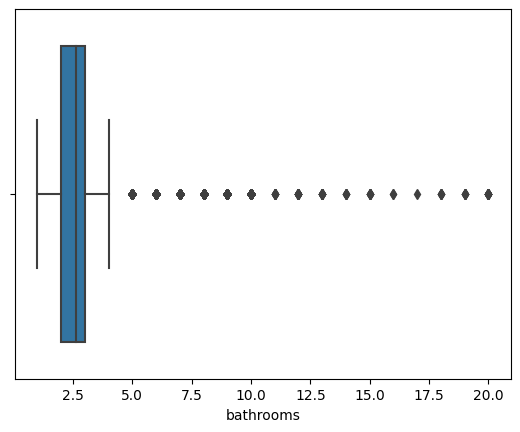

In [526]:
sns.boxplot(x = 'bathrooms', data = data)
plt.show()

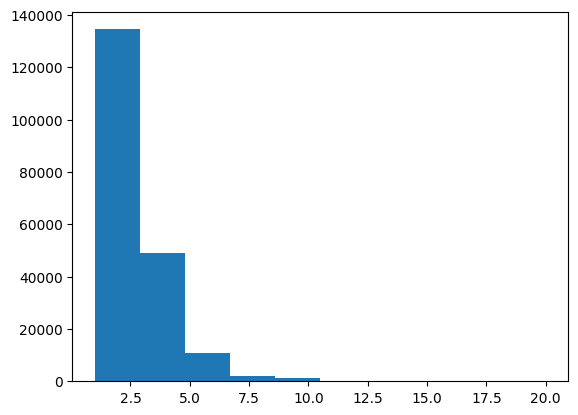

In [527]:
plt.hist(data['bathrooms']) 
plt.show()

In [528]:
# Eliminamos outliers simplificando el modelo, tomando como cantidad máxima 10 baños.
# todas las propiedades que tuvieran más de 10 baños, le imputo 10 baños.
# son 6 veces sigma

In [529]:
def outliers_bathrooms (data):
    data.loc[data[data['bathrooms']>=10].index,'bathrooms']=10
    return data

In [530]:
data = outliers_bathrooms(data)

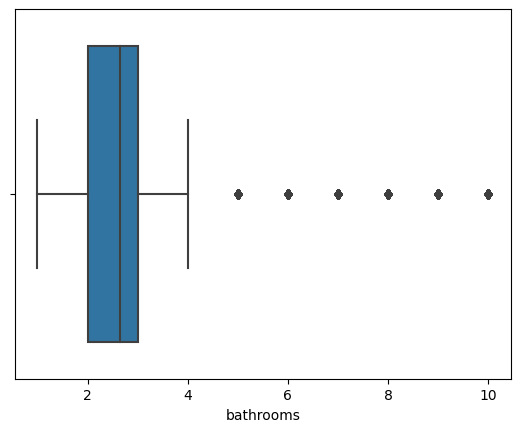

In [531]:
sns.boxplot(x = 'bathrooms', data = data)
plt.show()

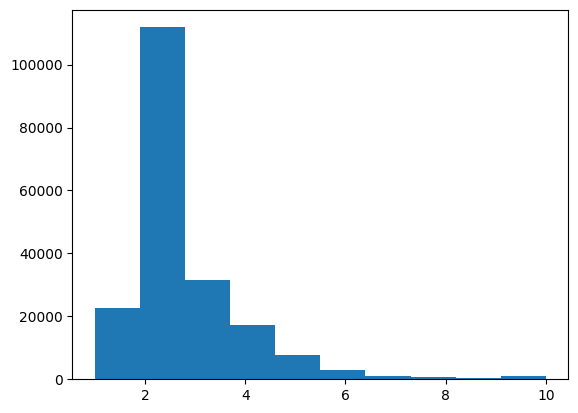

In [532]:
plt.hist(data['bathrooms']) 
plt.show()

In [533]:
# columna property_type
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16526
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Parqueadero            10
Name: property_type, dtype: int64

In [534]:
# Podríamos considerar como outlier al valor Parqueadero, que son sólo 10 registros.
# Para no agregar posteriormente una variable dummy adicional, vamos a imputar a esos registros el valor 'Otro'

In [535]:
def outlier_property_type (data):
    data.loc[data[data['property_type']=='Parqueadero'].index,['property_type']]='Otro'
    return data

In [536]:
data = outlier_property_type (data)

In [537]:
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16536
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Name: property_type, dtype: int64

In [616]:
# incorporo una columna al modelo para intentar utilizar algo de info de la columna description.
# agregamos una columna que indique la cantidad de palabras que describen la propiedad, a ver si 
# avisos más descriptivos, con mas detalle aportan información sobre el precio de la propiedad.

def col_desc_total_words (data):    
    data['desc_tot_words']=data['description'].apply(lambda x: str(x).count(' '))
    return data

In [617]:
data = col_desc_total_words (data)

In [618]:
data['desc_tot_words'].describe()

count    197486.000000
mean         61.536013
std          45.288997
min           0.000000
25%          34.000000
50%          53.000000
75%          76.000000
max        1383.000000
Name: desc_tot_words, dtype: float64

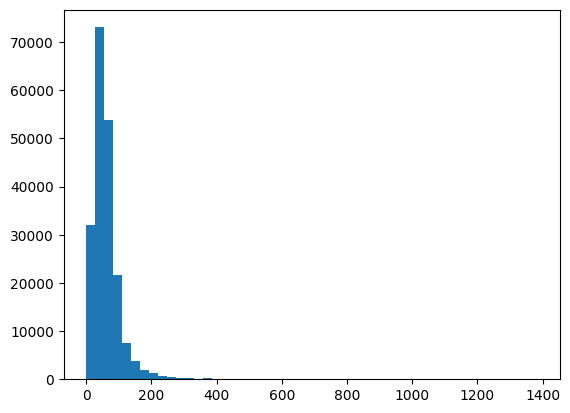

In [619]:
plt.hist(data['desc_tot_words'], bins =50) 
plt.show()

In [620]:
# trunco en 400 palabras

def truncar_cant_words(x):
    if x < 400:
        return x
    else:
        return 300


In [621]:
data['desc_tot_words']=data['desc_tot_words'].apply(truncar_cant_words)

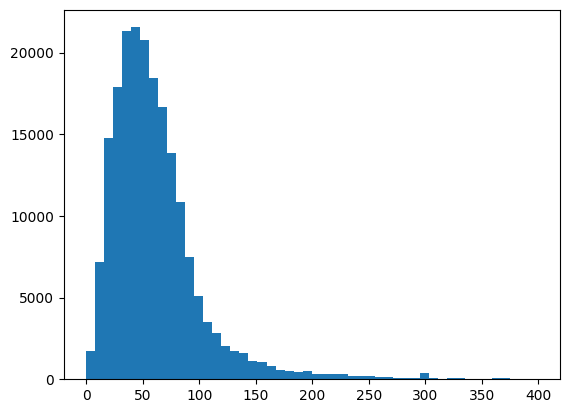

In [622]:
plt.hist(data['desc_tot_words'], bins =50) 
plt.show()

In [636]:
#agrego la columna 'target' con de acuerdo a la consigna.

def caro_barato(x):
    if x > media_precio_orig:
        return 1
    else:
        return 0

data['caro'] = data['price'].apply(lambda x: caro_barato(x))

In [637]:
data['caro'].describe()

count    197486.000000
mean          0.234741
std           0.423838
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: caro, dtype: float64

## Selección Features 1

In [804]:
#    # Quito columnas que no formarán parte del modelo
#
#   COLUMNA                 |       MOTIVO
# --------------------------+-----------------------------------------------------------
#   Unnamed: 0              |       (no agrega información para predecir, es un indice)              
#   id                      |       (no agrega información para predecir, es un indice)
#   ad_type                 |       (no aporta informacion, todo el mismo valor)
#   start_date              |       (no agrega información para predecir, es una fecha)
#   end_date                |       (no agrega información para predecir, es una fecha)
#   created_on              |       (no agrega información para predecir, es una fecha)
#   lat                     |       SE CONSIDERA
#   lon                     |       SE CONSIDERA
#   l1                      |       (info contenida en lat y long, ademas es monovalor)
#   l2                      |       (info contenida en lat y long)
#   l3                      |       (info contenida en lat y long)
#   l4                      |       (info contenida en lat y long)
#   l5                      |       (info contenida en lat y long)
#   l6                      |       (info contenida en lat y long)
#   rooms                   |       (descartar, muchos nulos) 
#   bedrooms                |       (descartar, muchos nulos)
#   bathrooms               |       SE CONSIDERA
#   surface_total           |       (descartar, muchos nulos)
#   surface_covered         |       (descartar, muchos nulos)
#   price                   |       (De acá se genera la variable target)
#   currency                |       (no aporta informacion, todo el mismo valor)
#   price_period            |       (muchos nulos, y monovalor que no tiene sentido al ser una operacion de venta)
#   title                   |       (por ahora no extraemos info de la misma)
#   description             |       (no se considera directamente, se representa con la info extraida en col desc_tot_words)
#   property_type           |       SE CONSIDERA
#   operation_type          |       (no aporta informacion, todo el mismo valor)
#   geometry                |       (info contenida en lat y long)
#   desc_tot_words          |       SE CONSIDERA
#   caro                    |       VAR target s/consigna (1 = caro / 0 = barato)        

# reservo a \data\, para avanzar con la incorporación de otras columnas al modelo quizás más adelante.
# avanzo con \data_model\ para evaluar las variables y comenzar a armar modelos

columnas = ['lat', 'lon', 'bathrooms', 'property_type',
 'desc_tot_words', 'price', 'caro']
data_model=pd.DataFrame()
data_model=data[columnas]    


In [782]:

data_model.head()

,lat,lon,bathrooms,property_type,desc_tot_words,price,caro
0,6.203000,-75.572000,4.0,Casa,168,9.000000e+09,1
1,4.722748,-74.073115,2.0,Apartamento,72,6.250000e+08,0
2,4.709000,-74.030000,2.0,Casa,72,4.200000e+08,0
3,7.117263,-73.115667,1.0,Otro,100,1.310000e+09,1
4,6.244338,-75.573553,2.0,Apartamento,57,2.100000e+08,0


In [783]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             197486 non-null  float64
 1   lon             197486 non-null  float64
 2   bathrooms       197486 non-null  float64
 3   property_type   197486 non-null  object 
 4   desc_tot_words  197486 non-null  int64  
 5   price           197486 non-null  float64
 6   caro            197486 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 10.5+ MB


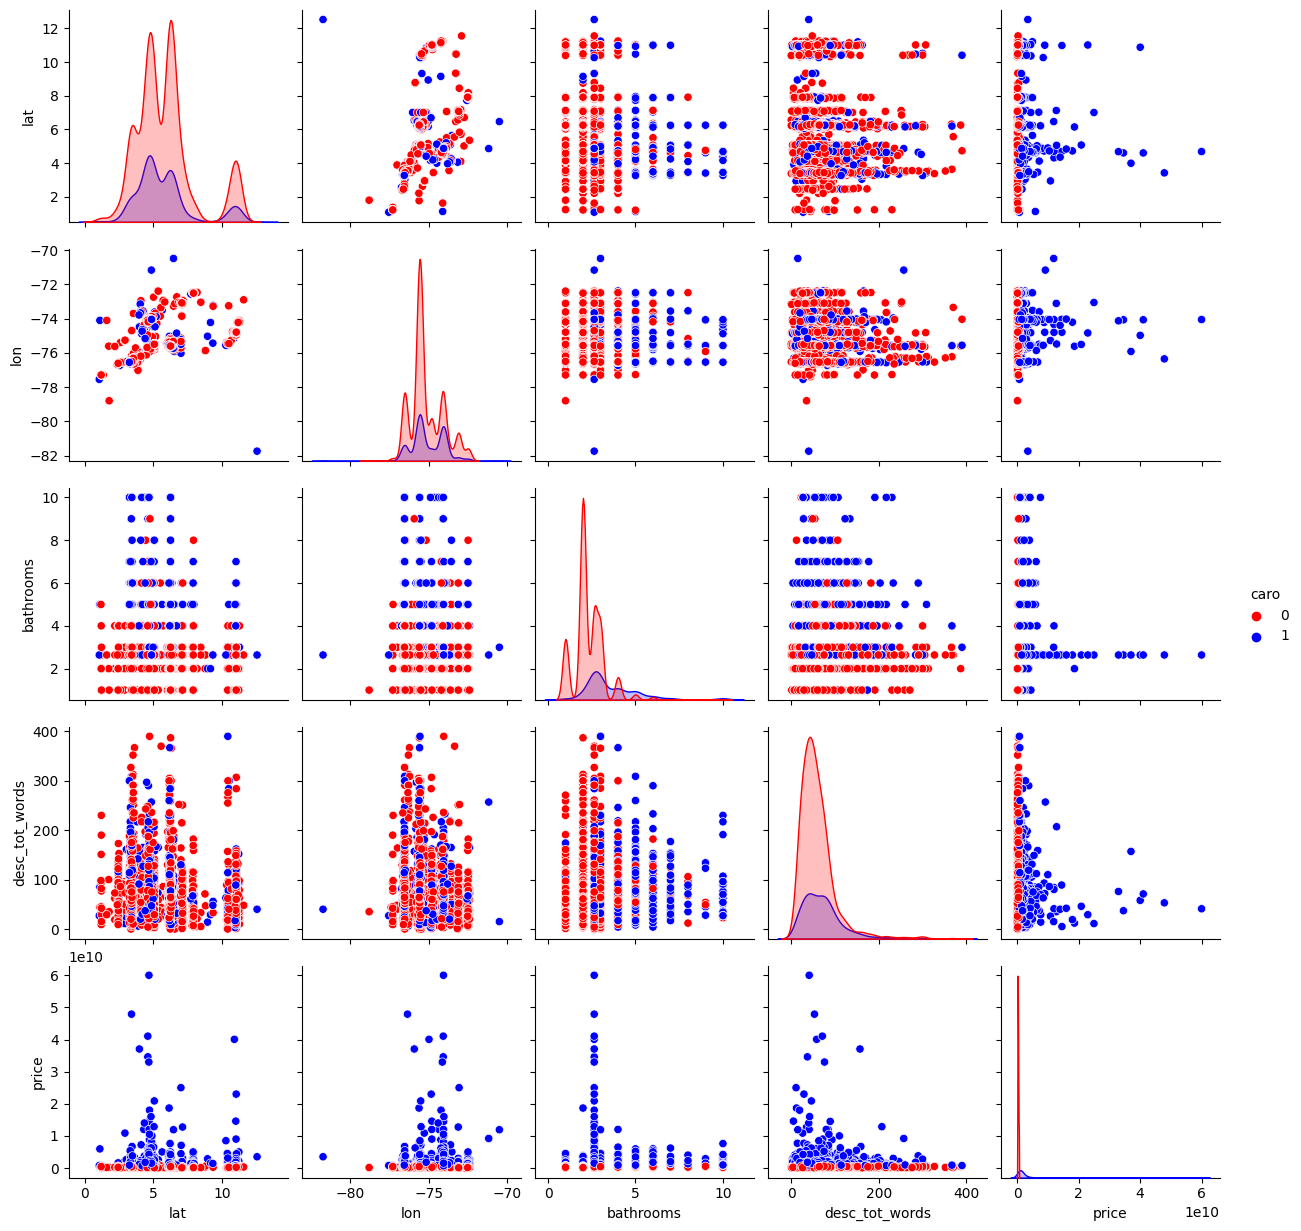

In [784]:
sns.pairplot(data_model.sample(5000), hue="caro", palette = ['r', 'b'])
plt.show()

## Escalado / Normalización

In [785]:
from sklearn.preprocessing import StandardScaler

In [786]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro
count,197486.000000,197486.000000,197486.000000,197486.000000,1.974860e+05,197486.000000
mean,5.819974,-75.113818,2.637229,61.192105,6.436051e+08,0.234741
std,2.085907,1.025720,1.262198,42.246073,1.944868e+09,0.423838
min,-4.212921,-81.728390,1.000000,0.000000,0.000000e+00,0.000000
25%,4.648000,-75.596795,2.000000,34.000000,2.000000e+08,0.000000
50%,5.075436,-75.525502,2.639279,53.000000,3.300000e+08,0.000000
75%,6.244338,-74.150000,3.000000,76.000000,6.000000e+08,0.000000
max,13.351917,-67.482570,10.000000,399.000000,3.450000e+11,1.000000


In [805]:
data_model.describe()
scaler_lat = StandardScaler()
scaler_lon = StandardScaler()
scaler_bath = StandardScaler()
scaler_desc_words = StandardScaler()


scaler_lat.fit(data_model[['lat']])
scaler_lon.fit(data_model[['lon']])
scaler_bath.fit(data_model[['bathrooms']])
scaler_desc_words.fit(data_model[['desc_tot_words']])


data_model['lat'] = scaler_lat.transform(data_model[['lat']])
data_model['lon'] = scaler_lon.transform(data_model[['lon']])
data_model['bathrooms'] = scaler_bath.transform(data_model[['bathrooms']])
data_model['desc_tot_words'] = scaler_desc_words.transform(data_model[['desc_tot_words']])


C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\737995848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lat'] = scaler_lat.transform(data_model[['lat']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\737995848.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lon'] = scaler_lon.transform(data_model[['lon']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\737995848.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [806]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000


## Codificación de Variables CAT

In [811]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              197486 non-null  float64
 1   lon              197486 non-null  float64
 2   bathrooms        197486 non-null  float64
 3   property_type    197486 non-null  object 
 4   desc_tot_words   197486 non-null  float64
 5   price            197486 non-null  float64
 6   caro             197486 non-null  int64  
 7   Apartamento      197486 non-null  int64  
 8   Casa             197486 non-null  int64  
 9   Otro             197486 non-null  int64  
 10  Lote             197486 non-null  int64  
 11  Local comercial  197486 non-null  int64  
 12  Finca            197486 non-null  int64  
 13  Oficina          197486 non-null  int64  
dtypes: float64(5), int64(8), object(1)
memory usage: 21.1+ MB


In [812]:
cols_ohe=list(data_model['property_type'].value_counts().index)
def onehot_property_type(data_model, cols_ohe):
    ''' cols_ohe tienen que ser la lista de columnas columnas del dataframe original, asi codifica igual en otro subset'''
    
    # agrego las columnas todas en 0
    data_model[cols_ohe]=0 

    # pongo un 1 en las posiciones que coincida el valor del registro property_type con el nombre de la col en cuestion
    for columna in cols_ohe:    
        data_model.loc[data_model[data_model['property_type']==columna].index,[columna]]=1
    return data_model



In [813]:
data_model = onehot_property_type(data_model, cols_ohe)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1003885170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0


In [815]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000,197486.000000,197486.000000,197486.000000,197486.000000,197486.00000,197486.000000,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741,0.508872,0.306290,0.083733,0.083555,0.00634,0.005742,0.005469
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838,0.499923,0.460953,0.276987,0.276720,0.07937,0.075559,0.073749
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [808]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000,197486.0,197486.0,197486.0,197486.0,197486.0,197486.0,197486.0
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [791]:
# from sklearn.preprocessing import OneHotEncoder

In [792]:
#data_encoded = data_model[['property_type']]
#ohe = OneHotEncoder(handle_unknown = 'ignore')
#data_encoded = pd.DataFrame(ohe.fit_transform(data_encoded).toarray())
#data_model = data_model.join(data_encoded)

In [818]:
data_model.isnull().sum()

lat                0
lon                0
bathrooms          0
property_type      0
desc_tot_words     0
price              0
caro               0
Apartamento        0
Casa               0
Otro               0
Lote               0
Local comercial    0
Finca              0
Oficina            0
dtype: int64

In [830]:
data_model.to_csv('df_train.csv')

## -----------------------------------------------------------------------

## Pasos a aplicar a dataset test antes de hacer predict

In [819]:
#abro la data del test
data_test = pd.read_csv('../properties_colombia_test.csv')


In [820]:
# hago las mismas transoformaciones, rellenado de nulos, etc. (excepto la quita de valores)

def transform_test(data):
    data = llenar_latitud(data)
    data = llenar_longitud(data)
    data = llenar_bathrooms (data)
    data = outliers_bathrooms(data)
    data = outlier_property_type(data)
    data = col_desc_total_words(data)
    data['desc_tot_words']=data['desc_tot_words'].apply(truncar_cant_words)
    
    return data



data_test = transform_test(data_test)

# Demora aprox 5 min, 30 seg

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1260512333.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1260512333.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [821]:
data_test.isnull().sum()

Unnamed: 0             0
id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
lat                    0
lon                    0
l1                     0
l2                     0
l3                     0
l4                 50776
l5                 56798
l6                 63486
rooms              56740
bedrooms           52447
bathrooms              0
surface_total      63536
surface_covered    62545
currency              17
price_period       53729
title                  0
description           27
property_type          0
operation_type         0
geometry               0
desc_tot_words         0
dtype: int64

In [822]:
# replico el uso de las columnas que componen el modelo para este subset

data_model_test = pd.DataFrame()
columnas_test = columnas = ['lat', 'lon', 'bathrooms', 'property_type','desc_tot_words']
data_model_test = data_test[columnas]

In [823]:
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words
count,65850.000000,65850.000000,65850.000000,65850.000000
mean,5.833646,-75.115216,2.638197,60.716234
std,2.100318,1.024412,1.255925,41.630425
min,-4.212921,-81.705052,1.000000,0.000000
25%,4.649456,-75.596142,2.000000,34.000000
50%,5.077178,-75.525287,2.639624,53.000000
75%,6.244338,-74.150851,3.000000,75.000000
max,13.338761,-67.924336,10.000000,399.000000


In [824]:
#replico el escalado de las variables del modelo

def scale_test(data_model):
    data_model['lat'] = scaler_lat.transform(data_model[['lat']])
    data_model['lon'] = scaler_lon.transform(data_model[['lon']])
    data_model['bathrooms'] = scaler_bath.transform(data_model[['bathrooms']])
    data_model['desc_tot_words'] = scaler_desc_words.transform(data_model[['desc_tot_words']])
    return data_model
data_model_test = scale_test(data_model_test)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\3662038155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lat'] = scaler_lat.transform(data_model[['lat']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\3662038155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lon'] = scaler_lon.transform(data_model[['lon']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\3662038155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [825]:
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words
count,65850.000000,65850.000000,65850.000000,65850.000000
mean,0.006555,-0.001363,0.000766,-0.011264
std,1.006911,0.998728,0.995033,0.985430
min,-4.809861,-6.425977,-1.297129,-1.448472
25%,-0.561157,-0.470232,-0.504858,-0.643662
50%,-0.356103,-0.401153,0.001897,-0.193914
75%,0.203444,0.938823,0.287412,0.326845
max,3.604575,7.009225,5.833307,7.996217


In [826]:
data_model_test['property_type'].value_counts()

Apartamento        33524
Casa               20084
Lote                5704
Otro                5379
Local comercial      434
Finca                377
Oficina              348
Name: property_type, dtype: int64

In [827]:
# replico la codificacion onehot usada previamente
data_model_test = onehot_property_type(data_model_test, cols_ohe)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1003885170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1003885170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16276\1003885170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [828]:
# Datos listos para pasar hacer predict
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000
mean,0.006555,-0.001363,0.000766,-0.011264,0.509096,0.304996,0.081686,0.086621,0.006591,0.005725,0.005285
std,1.006911,0.998728,0.995033,0.985430,0.499921,0.460409,0.273887,0.281281,0.080916,0.075448,0.072504
min,-4.809861,-6.425977,-1.297129,-1.448472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.561157,-0.470232,-0.504858,-0.643662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.356103,-0.401153,0.001897,-0.193914,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.203444,0.938823,0.287412,0.326845,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.604575,7.009225,5.833307,7.996217,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [829]:
data_model_test.to_csv('df_test.csv')

## ---------------------------------------------------------------

## MODELOS

In [ ]:
# se pueden importar los csvs ya preparados (df_test.csv y df_train.csv) y arrancar desde acá en un nuevo notebook

In [836]:
columnas_x = ['lat', 'lon', 'bathrooms', 'desc_tot_words', 'Apartamento', 'Casa', 'Otro', 'Lote', 'Local comercial', 'Finca', 'Oficina']
columna_y = ['caro']

X = data_model.loc[:,columnas_x]
y = data_model.loc[:,columna_y]

In [869]:
X_testigo_entrega = data_model_test.loc[:,columnas_x]

In [841]:
from sklearn.model_selection import train_test_split

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=0)

In [848]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

### 1. Arbol simple

In [860]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 50, random_state = 42) 
clf.fit(X_Train.values,Y_Train.values)
y_pred = clf.predict(X_Test.values)

In [861]:

print('Feature importance: ', clf.feature_importances_)
print('Accuracy: ', accuracy_score(Y_Test,y_pred))
print('Recall: ', recall_score(Y_Test,y_pred))

Feature importance:  [0.23059952 0.22262407 0.29117648 0.18757414 0.01648411 0.00877604
 0.0231619  0.00908478 0.00361537 0.00518526 0.00171832]
Accuracy:  0.9157012071619541
Recall:  0.8169098712446352


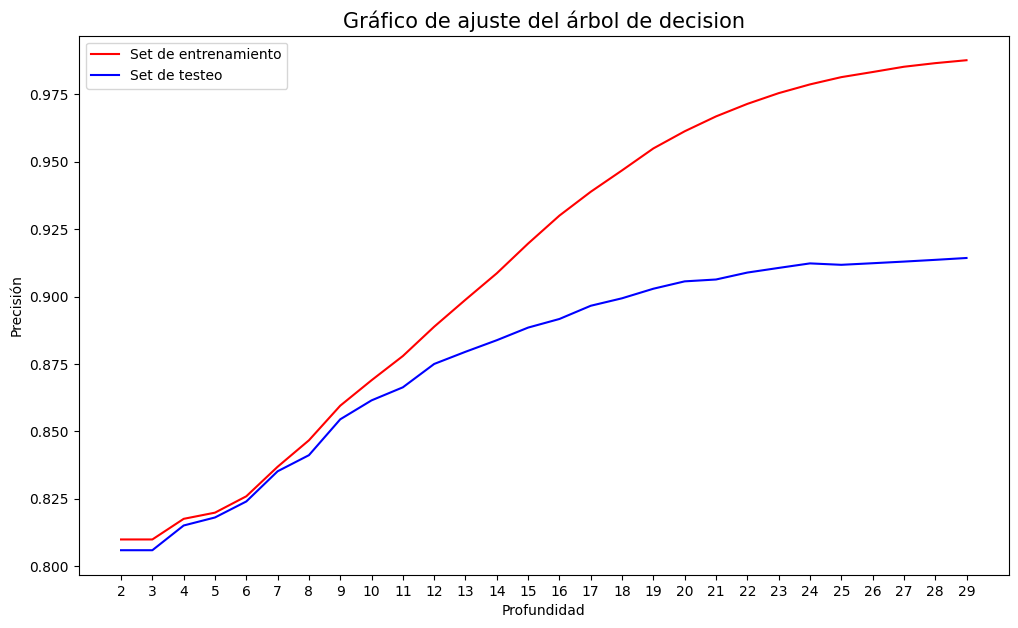

In [866]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(2, 30))

for deep in max_deep_list:
    clf_3 = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf_3.fit(X_Train, Y_Train)
    train_prec.append(clf_3.score(X_Train, Y_Train))
    eval_prec.append(clf_3.score(X_Test, Y_Test))


plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.xticks([i for i in max_deep_list])
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

In [867]:
# observamos que el óptimo se logra en profundidad 9 (posicion 8 en maxdepth)
clf_3 = DecisionTreeClassifier(max_depth=9, criterion='entropy')
clf_3.fit(X_Train, Y_Train)
y_pred = clf.predict(X_Test.values)
print('Accuracy: ', accuracy_score(Y_Test,y_pred))
print('Recall: ', recall_score(Y_Test,y_pred))

Accuracy:  0.9157012071619541
Recall:  0.8169098712446352


In [872]:
entrega_pred = clf.predict(X_testigo_entrega.values)

In [874]:
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# esta es la entrega n°1